<a href="https://colab.research.google.com/github/heebaaltaf/AUSTRAILIAN-HOUSING-MARKET-ANALYSIS/blob/main/alignedHEEBA_PANCREATIC_1_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pydicom


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 3.7 MB/s 


In [ ]:
pip install visdom


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 4.0 MB/s 
     |████████████████████████████████| 55 kB 4.1 MB/s 
  Created wheel for visdom: filename=visdom-0.2.3-py3-none-any.whl size=1417107 sha256=6001dcf719c8c683ec906b25f41261360a66c5507c495ea012022467c6a73abc
  Stored in directory: /root/.cache/pip/wheels/4d/73/32/0bbe55d2dccb9d80d3f020f474c15a5a1eef232817dcebe776
Successfully built visdom


In [ ]:
#Importing necessary Libraries.
#import tensorflow as tf
import copy
import os
import shutil
import os.path
import matplotlib.pyplot as plt
import glob # to find certain directories
import imageio
from IPython import display
from skimage.transform import resize
import numpy as np
import shutil
import random
import time
import datetime
import sys

from torch.autograd import Variable
import torch
from visdom import Visdom


#from keras.utils.vis_utils import plot_model
#from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Activation, Input, LeakyReLU,Concatenate,UpSampling2D
#from tensorflow.keras.initializers import RandomNormal
#from tensorflow.keras.models import Model
import pydicom as dicom
import PIL # optional
import pandas as pd
#import matplotlib.pyplot as plt
import pydicom.uid
from glob import glob

import scipy
import pickle

import argparse
import itertools

import torchvision.transforms as transforms
from torch.utils.data import DataLoader



import glob
import random
import os

from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image


In [ ]:

#If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:


path="/content/gdrive/My Drive/PROJECT-CBCT-CT/TCIA DATA/manifest-1661266724052"

In [ ]:

PICKLE_IMAGES=path+"/CT_ALIGNED_TRAIN"
CT_IMAGES = pickle.load(open(PICKLE_IMAGES,"rb"))
len(CT_IMAGES)

4123

In [ ]:
PICKLE_IMAGES2=path+"/CBCT_ALIGNED_TRAIN"
CBCT_IMAGES= pickle.load(open(PICKLE_IMAGES2,"rb"))
len(CBCT_IMAGES)

4402

In [ ]:
PICKLE_IMAGES_test=path+"/CT_ALIGNED_TEST"
CT_IMAGES_TEST= pickle.load(open(PICKLE_IMAGES_test,"rb"))
len(CT_IMAGES_TEST)

1491

In [ ]:
PICKLE_IMAGES2_test=path+"/CBCT_ALIGNED_TEST"
CBCT_IMAGES_TEST= pickle.load(open(PICKLE_IMAGES2_test,"rb"))
len(CBCT_IMAGES_TEST)


1288

In [ ]:
PICKLE_IMAGES2_path=path+"/CBCT_ALIGNED_TEST_F"
CBCT_path_TEST= pickle.load(open(PICKLE_IMAGES2_path,"rb"))
len(CBCT_path_TEST)

1288

In [ ]:
def NORMALIZE(tensor):
 # """ Normalize the images to [-1.0, 1.0]"""
  MIN_BOUND=-1000
  MAX_BOUND=1500
  tensor[tensor>1500] = 1500
  tensor[tensor<-1000] =-1000 
  tensor = (tensor - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
  
  #image[image<0] = 0.
  #tensor=(tensor-127.5)/127.5
  return tensor

In [ ]:
def crop_image3(image, display=False):

    # Create a mask with the background pixels
    
    if (np.all(image==0))==False:

      mask = image == 0
      width,height=image.shape
      
      coords = np.array(np.nonzero(~mask))
      top_left = np.min(coords, axis=1)
      bottom_right = np.max(coords, axis=1)
    # Remove the background
      croped_image = image[(top_left[0]+30):(bottom_right[0]-30),

                (top_left[1]+30):(bottom_right[1]-30)]
      return croped_image   

In [ ]:
def resize_img(X):
    Y = cv2.resize(X, (256, 256), interpolation = cv2.INTER_NEAREST)
   # Y= resize(X, (256, 256))
    return Y

In [ ]:
def custom_transform(image):

  image=crop_image3(image,display=False)
  image=resize_img(image)
  image=NORMALIZE(image)
  tensor=torch.Tensor(image)
  return tensor




In [ ]:
import cv2

In [ ]:

class CustomTensorDataset2(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        #assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        y = self.tensors[1][index]
        if self.transform:
            x = self.transform(x)
            y= self.transform(y)
      
            
        #return x,y
        return {'A': x, 'B': y}

    def __len__(self):
        return len(self.tensors[0])


In [ ]:
def tensor2image(tensor):
    image = 127.5*(tensor[0].cpu().float().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (1,1,1))
    return image

class Logger():
    def __init__(self, n_epochs, batches_epoch,start_epoch):
        self.viz = Visdom()
        self.n_epochs = n_epochs
        self.batches_epoch = batches_epoch
        self.epoch = 1
        self.batch = 1
        self.prev_time = time.time()
        self.mean_period = 0
        self.losses = {}
        self.loss_windows = {}
        self.image_windows = {}


    def log(self, losses=None, images=None):
        self.mean_period += (time.time() - self.prev_time)
        self.prev_time = time.time()

        sys.stdout.write('\rEpoch %03d/%03d [%04d/%04d] -- ' % (self.epoch, self.n_epochs, self.batch, self.batches_epoch))

        for i, loss_name in enumerate(losses.keys()):
            if loss_name not in self.losses:
                self.losses[loss_name] = losses[loss_name].item()
            else:
                self.losses[loss_name] += losses[loss_name].item()

            if (i+1) == len(losses.keys()):
                sys.stdout.write('%s: %.4f -- ' % (loss_name, self.losses[loss_name]/self.batch))
            else:
                sys.stdout.write('%s: %.4f | ' % (loss_name, self.losses[loss_name]/self.batch))

        batches_done = self.batches_epoch*(self.epoch - 1) + self.batch
        batches_left = self.batches_epoch*(self.n_epochs - self.epoch) + self.batches_epoch - self.batch 
        sys.stdout.write('ETA: %s' % (datetime.timedelta(seconds=batches_left*self.mean_period/batches_done)))

        # Draw images
        for image_name, tensor in images.items():
            if image_name not in self.image_windows:
                self.image_windows[image_name] = self.viz.image(tensor2image(tensor.data), opts={'title':image_name})
            else:
                self.viz.image(tensor2image(tensor.data), win=self.image_windows[image_name], opts={'title':image_name})

        # End of epoch
        if (self.batch % self.batches_epoch) == 0:
            # Plot losses
            for loss_name, loss in self.losses.items():
                if loss_name not in self.loss_windows:
                    self.loss_windows[loss_name] = self.viz.line(X=np.array([self.epoch]), Y=np.array([loss/self.batch]), 
                                                                    opts={'xlabel': 'epochs', 'ylabel': loss_name, 'title': loss_name})
                else:
                    self.viz.line(X=np.array([self.epoch]), Y=np.array([loss/self.batch]), win=self.loss_windows[loss_name], update='append')
                # Reset losses for next epoch
                self.losses[loss_name] = 0.0

            self.epoch += 1
            self.batch = 1
            sys.stdout.write('\n')
        else:
            self.batch += 1

        

class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [ ]:
def save_checkpoint(state, save_path):
    torch.save(state, save_path)


# To load the checkpoint
def load_checkpoint(ckpt_path, map_location=None):
    ckpt = torch.load(ckpt_path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % ckpt_path)
    return ckpt

In [ ]:
from visdom import Visdom

In [ ]:
! npm install -g localtunnel
get_ipython().system_raw('python3 -m pip install visdom')
get_ipython().system_raw('python3 -m visdom.server -port 8097 >> visdomlog.txt 2>&1 &')
get_ipython().system_raw('lt --port 8097 > url.txt 2>&1 &')
import time
time.sleep(5)
! cat url.txt
import visdom
time.sleep(5)
vis = visdom.Visdom(port='8097')
print(vis)
time.sleep(3)

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
updated 1 package in 0.613s


   ╭───────────────────────────────────────────────────────────────╮
   │                                                               │
   │      New major version of npm available! 6.14.8 → 9.2.0       │
   │   Changelog: https://github.com/npm/cli/releases/tag/v9.2.0   │
   │               Run npm install -g npm to update!               │
   │                                                               │
   ╰───────────────────────────────────────────────────────────────╯

your url is: https://cyan-doodles-refuse-104-199-182-209.loca.lt


In [ ]:
def generate_images(model1, prediction1, model2,prediction2):
    plt.figure(figsize=(8, 4))
    display_list = [model1, prediction1, model2, prediction2]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4,i+1)
        plt.title(title[i])
        plt.imshow(np.squeeze(tensor2image(display_list[i])),cmap='gray')
        plt.axis('off')

    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Namespace(batchSize=1, cuda=False, dataroot='G:/My Drive/PROJECT-CBCT-CT/TCIA DATA/manifest-1661266724052', decay_epoch=100, epoch=0, input_nc=1, lr=0.0002, n_cpu=0, n_epochs=200, output_nc=1, size=256)


 [*] Loading checkpoint from /content/gdrive/My Drive/PROJECT-CBCT-CT/TCIA DATA/manifest-1661266724052/Trained_Modelaligned/latest.ckpt succeed!
5
Epoch[6/205]
Epoch 001/200 [4123/4123] -- loss_G: 2.2427 | loss_G_identity: 0.1839 | loss_G_GAN: 1.6316 | loss_G_cycle: 0.4272 | loss_D: 0.0761 -- ETA: 6 days, 2:32:26.937648


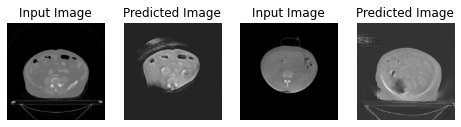

Epoch[7/205]
Epoch 002/200 [4123/4123] -- loss_G: 2.1991 | loss_G_identity: 0.1762 | loss_G_GAN: 1.6291 | loss_G_cycle: 0.3937 | loss_D: 0.0785 -- ETA: 6 days, 1:41:57.439010


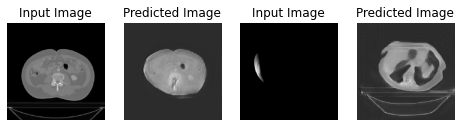

Epoch[8/205]
Epoch 003/200 [4123/4123] -- loss_G: 2.1988 | loss_G_identity: 0.1648 | loss_G_GAN: 1.6628 | loss_G_cycle: 0.3712 | loss_D: 0.0710 -- ETA: 6 days, 1:00:25.305972


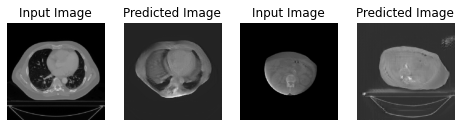

Epoch[9/205]
Epoch 004/200 [4123/4123] -- loss_G: 2.1977 | loss_G_identity: 0.1505 | loss_G_GAN: 1.6789 | loss_G_cycle: 0.3683 | loss_D: 0.0668 -- ETA: 6 days, 0:17:45.059678


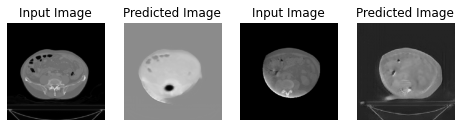

Epoch[10/205]
Epoch 005/200 [4123/4123] -- loss_G: 2.2145 | loss_G_identity: 0.1500 | loss_G_GAN: 1.6911 | loss_G_cycle: 0.3735 | loss_D: 0.0658 -- ETA: 5 days, 23:37:19.505177


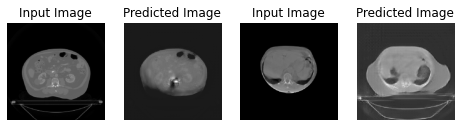

Epoch[11/205]
Epoch 006/200 [4123/4123] -- loss_G: 2.2279 | loss_G_identity: 0.1479 | loss_G_GAN: 1.7000 | loss_G_cycle: 0.3801 | loss_D: 0.0619 -- ETA: 5 days, 22:57:39.569616


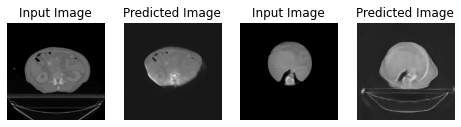

Epoch[12/205]
Epoch 007/200 [4123/4123] -- loss_G: 2.1881 | loss_G_identity: 0.1373 | loss_G_GAN: 1.6918 | loss_G_cycle: 0.3589 | loss_D: 0.0633 -- ETA: 5 days, 22:11:22.691630


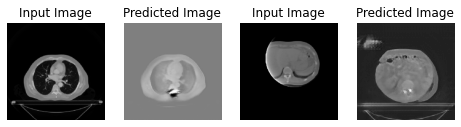

Epoch[13/205]
Epoch 008/200 [4123/4123] -- loss_G: 2.1905 | loss_G_identity: 0.1319 | loss_G_GAN: 1.7028 | loss_G_cycle: 0.3559 | loss_D: 0.0605 -- ETA: 5 days, 21:26:23.214140


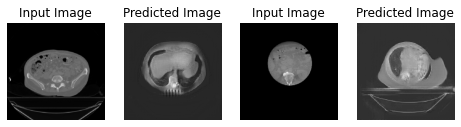

Epoch[14/205]
Epoch 009/200 [4123/4123] -- loss_G: 2.1920 | loss_G_identity: 0.1360 | loss_G_GAN: 1.6962 | loss_G_cycle: 0.3598 | loss_D: 0.0639 -- ETA: 5 days, 20:39:17.204628


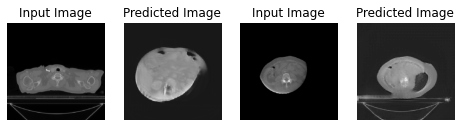

Epoch[15/205]
Epoch 010/200 [4123/4123] -- loss_G: 2.1770 | loss_G_identity: 0.1285 | loss_G_GAN: 1.6896 | loss_G_cycle: 0.3589 | loss_D: 0.0646 -- ETA: 5 days, 19:53:54.109789


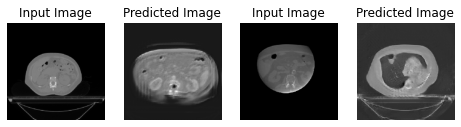

Epoch[16/205]
Epoch 011/200 [4123/4123] -- loss_G: 2.1622 | loss_G_identity: 0.1207 | loss_G_GAN: 1.7030 | loss_G_cycle: 0.3385 | loss_D: 0.0634 -- ETA: 5 days, 19:09:15.460312


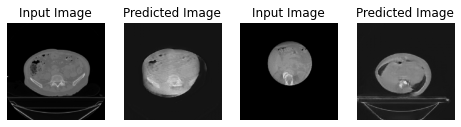

Epoch[17/205]
Epoch 012/200 [4123/4123] -- loss_G: 2.1441 | loss_G_identity: 0.1144 | loss_G_GAN: 1.6933 | loss_G_cycle: 0.3364 | loss_D: 0.0673 -- ETA: 5 days, 18:23:57.423654


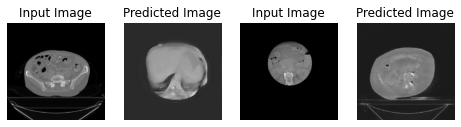

Epoch[18/205]
Epoch 013/200 [3008/4123] -- loss_G: 2.1847 | loss_G_identity: 0.1156 | loss_G_GAN: 1.7115 | loss_G_cycle: 0.3575 | loss_D: 0.0615 -- ETA: 5 days, 17:50:29.731049

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--epoch', type=int, default=0, help='starting epoch')
parser.add_argument('--n_epochs', type=int, default=200, help='number of epochs of training')
parser.add_argument('--batchSize', type=int, default=1, help='size of the batches')
parser.add_argument('--dataroot', type=str, default="G:/My Drive/PROJECT-CBCT-CT/TCIA DATA/manifest-1661266724052", help='root directory of the dataset')
parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate')
parser.add_argument('--decay_epoch', type=int, default=100, help='epoch to start linearly decaying the learning rate to 0')
parser.add_argument('--size', type=int, default=256, help='size of the data crop (squared assumed)')
parser.add_argument('--input_nc', type=int, default=1, help='number of channels of input data')
parser.add_argument('--output_nc', type=int, default=1, help='number of channels of output data')
parser.add_argument('--cuda', action='store_true', help='use GPU computation')
parser.add_argument('--n_cpu', type=int, default=0, help='number of cpu threads to use during batch generation')
opt =  parser.parse_args(args=[])
print(opt)

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

###### Definition of variables ######
# Networks
netG_A2B = Generator(opt.input_nc, opt.output_nc)
netG_B2A = Generator(opt.output_nc, opt.input_nc)
netD_A = Discriminator(opt.input_nc)
netD_B = Discriminator(opt.output_nc)


if opt.cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()

netG_A2B.apply(weights_init_normal).cuda()
netG_B2A.apply(weights_init_normal).cuda()
netD_A.apply(weights_init_normal).cuda()
netD_B.apply(weights_init_normal).cuda()

# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=opt.lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)



checkpoint_dir=path+'/Trained_Modelaligned'
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

try:
    ckpt =load_checkpoint('%s/latest.ckpt' % (checkpoint_dir))
    start_epoch = ckpt['epoch']
    netG_A2B.load_state_dict(ckpt['netG_A2B.pth'])
    netG_B2A.load_state_dict(ckpt['netG_B2A.pth'])
    netD_A.load_state_dict(ckpt['netD_A.pth'])
    netD_B.load_state_dict(ckpt['netD_B.pth'])
    optimizer_G.load_state_dict(ckpt['optimizer_G'])
    optimizer_D_A.load_state_dict(ckpt['optimizer_D_A'])
    optimizer_D_B.load_state_dict(ckpt['optimizer_D_B'])
    print(start_epoch)  
except:
    print(' [*] No checkpoint!')
    start_epoch = 0
# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor# if opt.cuda else torch.Tensor
input_A = Tensor(opt.batchSize, opt.input_nc, opt.size, opt.size)
input_B = Tensor(opt.batchSize, opt.output_nc, opt.size, opt.size)
target_real = Variable(Tensor(1).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(1).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Dataset loader
#transforms_ = [ transforms.Resize(int(opt.size*1.12), Image.BICUBIC), 
               # transforms.RandomCrop(opt.size), 
               # transforms.RandomHorizontalFlip(),
               # transforms.ToTensor(),
               # transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
transforms_ = [ transforms.Resize(int(opt.size*1.12), Image.BICUBIC), 
                transforms.RandomCrop(opt.size), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor()]               
#dataloader = DataLoader(ImageDataset(tensors=(tensor_x, tensor_y), transforms_=transforms_, unaligned=True), 
                        #batch_size=opt.batchSize, shuffle=True, num_workers=opt.n_cpu)
dataloader = DataLoader(CustomTensorDataset2(tensors=(CT_IMAGES, CBCT_IMAGES),transform= custom_transform), 
                        batch_size=opt.batchSize, shuffle=True, num_workers=opt.n_cpu)
# Loss plot
logger = Logger(opt.n_epochs, len(dataloader),start_epoch)
###################################

###### Training ######
for epoch in range(opt.epoch, opt.n_epochs):
    print("Epoch[%d/%d]"%(start_epoch+epoch+1, (start_epoch+opt.n_epochs)))
    for i, batch in enumerate(dataloader):
        # Set model input
        
        real_A = Variable(input_A.copy_((batch['A'])))
        real_B = Variable(input_B.copy_((batch['B'])))

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################

        # Progress report (http://localhost:8097)
        logger.log({'loss_G': loss_G, 'loss_G_identity': (loss_identity_A + loss_identity_B), 'loss_G_GAN': (loss_GAN_A2B + loss_GAN_B2A),
                    'loss_G_cycle': (loss_cycle_ABA + loss_cycle_BAB), 'loss_D': (loss_D_A + loss_D_B)}, 
                    images={'real_A': real_A, 'fake_B': fake_B,'real_B': real_B, 'fake_A': fake_A})
    
    #print('Epoch [%d/%d], Batch [%d/%d], loss_D: %.4f, loss_G: %.4f' % (epoch+1, opt.n_epochs,i+1, len(dataloader), loss_G, (loss_D_A + loss_D_B))) 
    #print("epoch[%d/%d]"%(start_epoch+1,opt.n_epochs)) 
    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    generate_images(real_A, fake_B, real_B,fake_A)
    save_checkpoint({'epoch': epoch + 1,
           'netG_A2B.pth':netG_A2B.state_dict(),
           'netG_B2A.pth':netG_B2A.state_dict(),
           'netD_A.pth':netD_A.state_dict(), 
           'netD_B.pth':netD_B.state_dict(),
           'optimizer_D_A':optimizer_D_A.state_dict(),
           'optimizer_D_B':optimizer_D_B.state_dict(),          
           'optimizer_G':optimizer_G.state_dict()},
           '%s/latest.ckpt' % (checkpoint_dir))

    # Save models checkpoints
    #torch.save(netG_A2B.state_dict(), 'output/netG_A2B.pth')
    #torch.save(netG_B2A.state_dict(), 'output/netG_B2A.pth')
    #torch.save(netD_A.state_dict(), 'output/netD_A.pth')
    #torch.save(netD_B.state_dict(), 'output/netD_B.pth')